In [1]:

import pandas as pd

train_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/train_dataset.csv")
val_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/val_dataset.csv")
test_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/test_dataset.csv")



In [2]:
# Installation of all necessary libraries.
!pip install nltk
!pip install spacy
!pip install emoji
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 92.3 MB/s eta 0:00:00:00:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# Importing libraries
import re
import string
import emoji
import nltk
import spacy
import pandas as pd

from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from tqdm.notebook import tqdm
tqdm.pandas()  

# Downloading nltk 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

# Stopwords
stop_words = set(stopwords.words('english'))

# Stemmers
porter_stemmer = PorterStemmer()
snowball_stemmer = SnowballStemmer(language='english')

# Lemmatizer
lemmatizer = WordNetLemmatizer()

# SpaCy (without parser/NER for better performance)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [4]:
#lowercasing in training, validation and test set
train_df['Text'] = train_df['Text'].str.lower()
val_df['Text'] = val_df['Text'].str.lower()
test_df['Text'] = test_df['Text'].str.lower()

# Check for tweets that still contain uppercase letters.
uppercase_in_train = train_df['Text'].str.contains(r'[A-Z]').sum()
uppercase_in_val = val_df['Text'].str.contains(r'[A-Z]').sum()
uppercase_in_test = test_df['Text'].str.contains(r'[A-Z]').sum()

print(f"Uppercase in train: {uppercase_in_train}")
print(f"Uppercase in val: {uppercase_in_val}")
print(f"Uppercase in test: {uppercase_in_test}")

Uppercase in train: 0
Uppercase in val: 0
Uppercase in test: 0


In [5]:
# Dictionary for correcting misspelled words
correction_dict = {
    "ur": "you are", "u": "you", "heartsy": "heart", "What's": "what is", "we've": "we have", 
    "i'm": "i am", "gta": "got to", "schbag": "shoulder bag", "won't": "will not", 
    "it's": "it is", "2night": "tonight", "don't": "do not", "waitin": "waiting",
    "depro": "depressed", "omg": "oh my god", "btw": "by the way", "tweeps": "twitter", 
    "tommorow": "tommorrow", "thru": "through", "yum": "yummy", "can't": "cannot", 
    "you're": "you are", "ap": "autograph page", "thingy": "thing", "pic": "picture",
    "there's": "there is", "1st": "first", "limo": "limosine", "yeh": "yes", "sumtimes": "sometimes", 
}
# Dictionary for correcting slang words
slang_dict = {
    "2day": "today","2moro": "tomorrow","2nite": "tonight","4ever": "forever","b4": "before","bday": "birthday","bf": "boyfriend","bff": "best friend forever",
    "brb": "be right back","btw": "by the way","cya": "see you","dm": "direct message","fb": "facebook","g2g": "got to go","gg": "good game",
    "gr8": "great","h8": "hate","idk": "i don't know","imo": "in my opinion","irl": "in real life","jk": "just kidding","l8r": "later",
    "lol": "laugh out loud","msg": "message","nvm": "never mind","omg": "oh my god","plz": "please","ppl": "people","rofl": "rolling on the floor laughing","sry": "sorry",
    "sup": "what's up","thx": "thanks","thru": "through","ttyl": "talk to you later","u": "you","ur": "your","w8": "wait","wtf": "what the fuck","yolo": "you only live once",
    "y": "why","r": "are","wanna": "want to","gonna": "going to","gotta": "got to","lemme": "let me","ain't": "is not","cuz": "because","dunno": "do not know",
    "gimme": "give me","kinda": "kind of","sorta": "sort of","wanna": "want to","ya": "you","tho": "though","da": "the","dat": "that",
    "dis": "this","dem": "them","gud": "good","luv": "love","nite": "night","coz": "because","smh": "shaking my head","fam": "family","lit": "amazing","dope": "cool","cap": "lie",
    "no cap": "no lie","finna": "fixing to","bet": "okay","yeet": "throw","deadass": "seriously","sus": "suspicious","salty": "bitter",
    "basic": "mainstream","clapback": "witty response","flex": "show off","lowkey": "somewhat","highkey": "very","goat": "greatest of all time",
    "savage": "ruthless","tea": "gossip","vibe": "feeling","bussin": "really good","simp": "someone overly attentive","chill": "relax","ghosted": "ignored",
    "squad": "group of friends","broke": "no money","turnt": "excited","hmu": "hit me up","wyd": "what are you doing","wya": "where are you","idc": "i don’t care","ikr": "i know right","ily": "i love you",
    "imho": "in my humble opinion","lmk": "let me know","tbh": "to be honest","tfw": "that feeling when","wyd": "what you doing","y’all": "you all",
}


# Function to correct words
def correct_words(text):
    for wrong, correct in correction_dict.items():
        text = re.sub(rf"\b{wrong}\b", correct, text)
    for wrong, correct in slang_dict.items():
        text = re.sub(rf"\b{wrong}\b", correct, text)
    return text

#train_df["Text"] = train_df["Text"].apply(correct_words)
#val_df["Text"] = val_df["Text"].apply(correct_words)
#test_df["Text"] = test_df["Text"].apply(correct_words)

In [6]:
# stopwords
stop_words = set(stopwords.words('english'))

# Important stopwordswhich we don't want to remove
important_stopwords = {
    'not', 'no', 'never', 'none', 'nor',
    'very', 'too',
    'always', 'ever', 'barely', 'hardly', 'rarely', 'scarcely',
    'should', 'would', 'could',
    "can't", "won't", "isn't", "aren't", "wasn't", "don't", "didn't", "doesn't"
}

# Final list of stopwords ( without the important words )
custom_stopwords = stop_words - important_stopwords

In [7]:
# Function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

train_df['Text'] = train_df['Text'].apply(remove_punctuation)
val_df['Text'] = val_df['Text'].apply(remove_punctuation)
test_df['Text'] = test_df['Text'].apply(remove_punctuation)

# Checking if everything worked well 
def has_punctuation(text):
    return bool(re.search(r"[^\w\s]", text))

print("Train:", train_df['Text'].apply(has_punctuation).sum(), "tweets with punctuation")
print("Val:", val_df['Text'].apply(has_punctuation).sum())
print("Test:", test_df['Text'].apply(has_punctuation).sum())

Train: 1414 tweets with punctuation
Val: 346
Test: 203


In [8]:
# Function to remove URLs
def remove_urls(text):
    return re.sub(r"http\S+|www\S+|ftp\S+", "", text)

train_df['Text'] = train_df['Text'].apply(remove_urls)
val_df['Text'] = val_df['Text'].apply(remove_urls)
test_df['Text'] = test_df['Text'].apply(remove_urls)

# Checking for URLs
url_pattern = re.compile(r"http\S+|www\S+|ftp\S+")

remaining_train = train_df['Text'].apply(lambda x: bool(url_pattern.search(x))).sum()
remaining_val = val_df['Text'].apply(lambda x: bool(url_pattern.search(x))).sum()
remaining_test = test_df['Text'].apply(lambda x: bool(url_pattern.search(x))).sum()

print(f"URLs remaining in train: {remaining_train}")
print(f"URLs remaining in val: {remaining_val}")
print(f"URLs remaining in test: {remaining_test}")

URLs remaining in train: 0
URLs remaining in val: 0
URLs remaining in test: 0


In [9]:
# Function to replace mentions ex. @argiro -> @user 
def replace_mentions(text):
    return re.sub(r"@\w+", "@user", text)
# Function to remove all the mentions ( ### EXP ###)
def remove_mentions(text):
    return re.sub(r"@\w+", "", text)

train_df['Text'] = train_df['Text'].apply(replace_mentions)
val_df['Text'] = val_df['Text'].apply(replace_mentions)
test_df['Text'] = test_df['Text'].apply(replace_mentions)

#Checking 
mention_pattern = re.compile(r"@\w+")

remaining_train = train_df['Text'].apply(lambda x: bool(mention_pattern.search(x))).sum()
remaining_val = val_df['Text'].apply(lambda x: bool(mention_pattern.search(x))).sum()
remaining_test = test_df['Text'].apply(lambda x: bool(mention_pattern.search(x))).sum()

print(f"Mentions remaining in train: {remaining_train}")
print(f"Mentions remaining in val: {remaining_val}")
print(f"Mentions remaining in test: {remaining_test}")

Mentions remaining in train: 0
Mentions remaining in val: 0
Mentions remaining in test: 0


In [10]:
# Function to replace emails ex. argiro@gmail.com -> EMAIL
def replace_emails(text):
    return re.sub(r'\S+@\S+', 'EMAIL', text)

# Function to remove all the emails( ### EXP ###)
def remove_emails(text):
    return re.sub(r'\S+@\S+', '', text)

train_df['Text'] = train_df['Text'].apply(replace_emails)
val_df['Text'] = val_df['Text'].apply(replace_emails)
test_df['Text'] = test_df['Text'].apply(replace_emails)

#Checking 
email_pattern = re.compile(r'\S+@\S+')

remaining_train = train_df['Text'].apply(lambda x: bool(email_pattern.search(x))).sum()
remaining_val = val_df['Text'].apply(lambda x: bool(email_pattern.search(x))).sum()
remaining_test = test_df['Text'].apply(lambda x: bool(email_pattern.search(x))).sum()

print(f"Emails remaining in train: {remaining_train}")
print(f"Emails remaining in val: {remaining_val}")
print(f"Emails remaining in test: {remaining_test}")

Emails remaining in train: 0
Emails remaining in val: 0
Emails remaining in test: 0


In [11]:
# Function to remove # from hashtags
def remove_hashtag_symbol(text):
    return re.sub(r"#", "", text)
    
train_df['Text'] = train_df['Text'].apply(remove_hashtag_symbol)
val_df['Text'] = val_df['Text'].apply(remove_hashtag_symbol)
test_df['Text'] = test_df['Text'].apply(remove_hashtag_symbol)

In [12]:
#Split hashtags (### EXP ###)
!pip install wordninja
import wordninja

def split_hashtags(text):
    words = []
    for token in text.split():
        if token.startswith("#"):
            split = wordninja.split(token[1:]) 
            words.extend(split)
        else:
            words.append(token)
    return " ".join(words)

#train_df['text'] = train_df['text'].apply(split_hashtags)
#val_df['text'] = val_df['text'].apply(split_hashtags)
#test_df['text'] = test_df['text'].apply(split_hashtags)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 12.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541530 sha256=cf353e278a9b50d0d7abe4c1cf8f64a8f268442423e056d1e4fcf9328339e048
  Stored in directory: /root/.cache/pip/wheels/e6/66/9c/712044a983337f5d44f90abcd244bd4b8ad28ee64750404b50
Successfully built wordninja


In [13]:
# Function to replace emojis ex. 😊 → " smile "
def replace_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))  
    
# Function to remove emojis ( ### EXP ###)
def remove_emojis(text):
    return emoji.replace_emoji(text, "")

train_df['Text'] = train_df['Text'].apply(replace_emojis)
val_df['Text'] = val_df['Text'].apply(replace_emojis)
test_df['Text'] = test_df['Text'].apply(replace_emojis)

In [14]:
# Function to replace phones 
def replace_phones(text):
    return re.sub(r'\b\d{10,}\b', 'PHONE', text)
#Function to remove phones 
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

train_df['Text'] = train_df['Text'].apply(replace_phones)
val_df['Text'] = val_df['Text'].apply(replace_phones)
test_df['Text'] = test_df['Text'].apply(replace_phones)

train_df['Text'] = train_df['Text'].apply(remove_numbers)
val_df['Text'] = val_df['Text'].apply(remove_numbers)
test_df['Text'] = test_df['Text'].apply(remove_numbers)


digit_check = lambda x: bool(re.search(r"\d", x))

print("Digits remaining in train:", train_df['Text'].apply(digit_check).sum())
print("Digits remaining in val:", val_df['Text'].apply(digit_check).sum())
print("Digits remaining in test:", test_df['Text'].apply(digit_check).sum())

Digits remaining in train: 0
Digits remaining in val: 0
Digits remaining in test: 0


In [15]:
#Function to correct the texts ex. goooood -> good 
def remove_repeated_letters(text):
    return re.sub(r'(\w)\1{2,}', r'\1\1', text)

train_df['Text'] = train_df['Text'].apply(remove_repeated_letters)
val_df['Text'] = val_df['Text'].apply(remove_repeated_letters)
test_df['Text'] = test_df['Text'].apply(remove_repeated_letters)

#Correcting the texts with TextBlob (### EXP ###)
!pip install textblob
from textblob import TextBlob

def correct_spelling(text):
    return str(TextBlob(text).correct())

#Correcting the texts with SymSpell (### EXP ###)
!pip install symspellpy
!wget https://raw.githubusercontent.com/wolfgarbe/SymSpell/master/SymSpell/frequency_dictionary_en_82_765.txt -O frequency_dict.txt
from symspellpy.symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

dictionary_path = "frequency_dict.txt"  # ή το path στο kaggle dir
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

def correct_spelling_symspell(text):
    corrected_tokens = []
    for word in text.split():
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        if suggestions:
            corrected_tokens.append(suggestions[0].term)
        else:
            corrected_tokens.append(word)
    return " ".join(corrected_tokens)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 38.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 11.6 MB/s eta 0:00:00
--2025-05-20 21:04:45--  https://raw.githubusercontent.com/wolfgarbe/SymSpell/master/SymSpell/frequency_dictionary_en_82_765.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332881 (1.3M) [text/plain]
Saving to: ‘frequency_dict.txt’

frequency_dict.txt  100%[===================>]   1.27M  --.-KB/s    in 0.04s   

2025-05-20 21:04:45 (34.7 MB/s) - ‘frequency_dict.txt’ saved [1332881/1332881]



In [16]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

def apply_lemmatization(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    lemmatized_tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in tagged_tokens
    ]
    return " ".join(lemmatized_tokens)

#train_df['Text'] = train_df['Text'].apply(apply_lemmatization)
#val_df['Text'] = val_df['Text'].apply(apply_lemmatization)
#test_df['Text'] = test_df['Text'].apply(apply_lemmatization)

#print(train_df['Text'].sample(5).tolist())

In [17]:
# Lemmatization with spaCy  (### EXP ###)
def apply_spacy_lemmatization(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

#train_df['Text'] = train_df['Text'].apply(apply_spacy_lemmatization)
#val_df['Text'] = val_df['Text'].apply(apply_spacy_lemmatization)
#test_df['Text'] = test_df['Text'].apply(apply_spacy_lemmatization)

#print(train_df['Text'].sample(5).tolist())

In [18]:
# Porter stemming 
porter = PorterStemmer()

def apply_porter_stemming(text):
    tokens = word_tokenize(text)
    stemmed_tokens = [porter.stem(word) for word in tokens]
    return " ".join(stemmed_tokens)

#train_df['Text'] = train_df['Text'].apply(apply_porter_stemming)
##val_df['Text'] = val_df['Text'].apply(apply_porter_stemming)
#test_df['Text'] = test_df['Text'].apply(apply_porter_stemming)

#print(train_df['Text'].sample(5).tolist())

In [19]:
# Snowball stemming
snowball = SnowballStemmer(language="english")

def apply_snowball_stemming(text):
    tokens = word_tokenize(text)
    stemmed_tokens = [snowball.stem(word) for word in tokens]
    return " ".join(stemmed_tokens)

#train_df['Text'] = train_df['Text'].apply(apply_snowball_stemming)
#val_df['Text'] = val_df['Text'].apply(apply_snowball_stemming)
#test_df['Text'] = test_df['Text'].apply(apply_snowball_stemming)
#print(train_df['Text'].sample(5).tolist())

In [20]:
#Removing the empty tweets 
def remove_empty_tweets(df):
    return df[df['Text'].str.strip().astype(bool)]
    
#train_df = remove_empty_tweets(train_df)
#val_df = remove_empty_tweets(val_df)
#test_df = remove_empty_tweets(test_df)

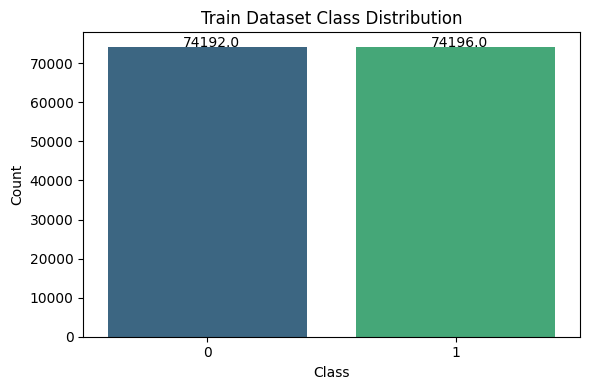

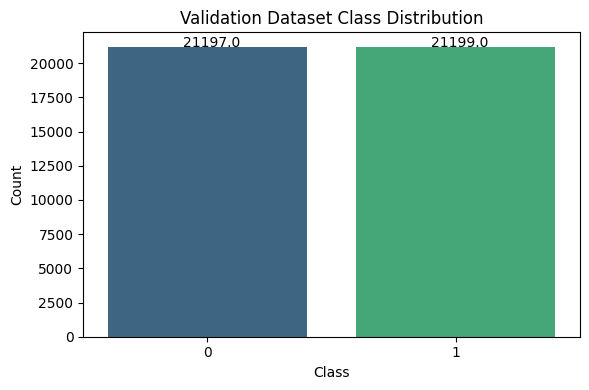

In [21]:
#Barplot for checking balanced / imbalaced classes
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(df, title, label_col='Label'):
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(data=df, x=label_col, palette='viridis')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height() + 5))
    
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_df, "Train Dataset Class Distribution")
plot_class_distribution(val_df, "Validation Dataset Class Distribution")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


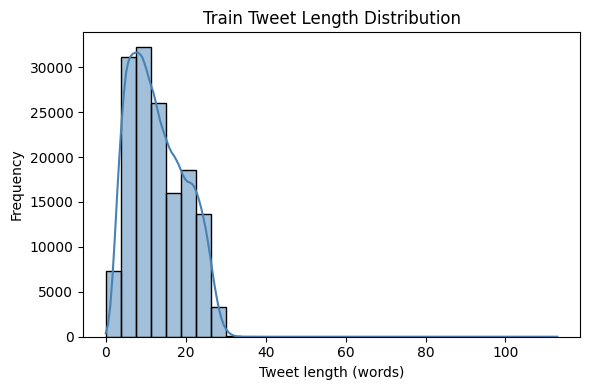

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


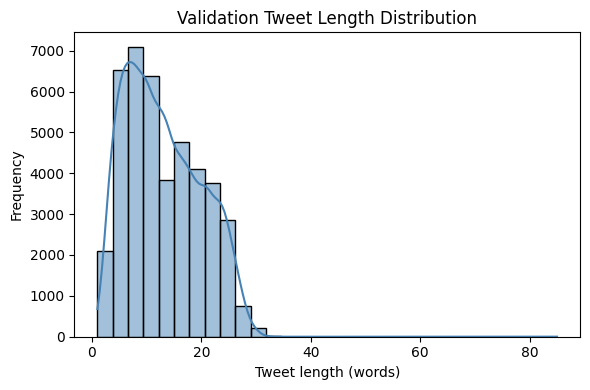

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


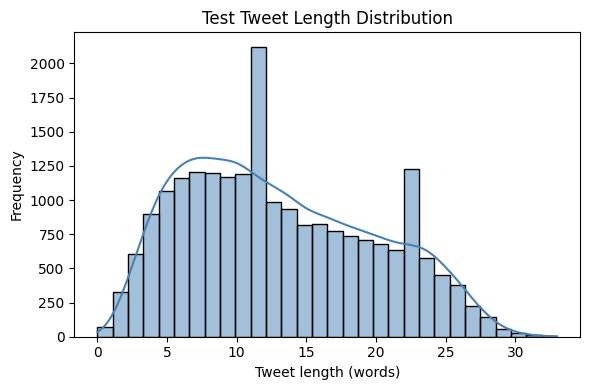

Train tweet length stats:
count    148388.000000
mean         12.986987
std           6.822162
min           0.000000
25%           7.000000
50%          12.000000
75%          18.000000
max         113.000000
Name: tweet_length, dtype: float64
Validation tweet length stats:
count    42396.000000
mean        13.008421
std          6.834402
min          1.000000
25%          7.000000
50%         12.000000
75%         18.000000
max         85.000000
Name: tweet_length, dtype: float64
Very short tweets in train (≤2 words): 2754
Very long tweets in train (≥50 words): 4


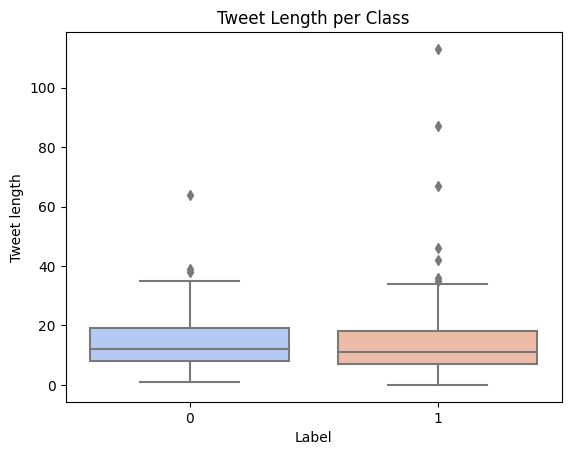

In [22]:
# Length of tweets
train_df['tweet_length'] = train_df['Text'].apply(lambda x: len(x.split()))
val_df['tweet_length'] = val_df['Text'].apply(lambda x: len(x.split()))
test_df['tweet_length'] = test_df['Text'].apply(lambda x: len(x.split()))

# Historigram

def plot_length_distribution(df, title):
    plt.figure(figsize=(6, 4))
    sns.histplot(df['tweet_length'], bins=30, kde=True, color='steelblue')
    plt.title(title)
    plt.xlabel("Tweet length (words)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_length_distribution(train_df, "Train Tweet Length Distribution")
plot_length_distribution(val_df, "Validation Tweet Length Distribution")
plot_length_distribution(test_df, "Test Tweet Length Distribution")

print("Train tweet length stats:")
print(train_df['tweet_length'].describe())

print("Validation tweet length stats:")
print(val_df['tweet_length'].describe())

print("Very short tweets in train (≤2 words):", (train_df['tweet_length'] <= 2).sum())
print("Very long tweets in train (≥50 words):", (train_df['tweet_length'] >= 50).sum())


#Boxplot
sns.boxplot(data=train_df, x='Label', y='tweet_length', palette='coolwarm')
plt.title("Tweet Length per Class")
plt.xlabel("Label")
plt.ylabel("Tweet length")
plt.show()

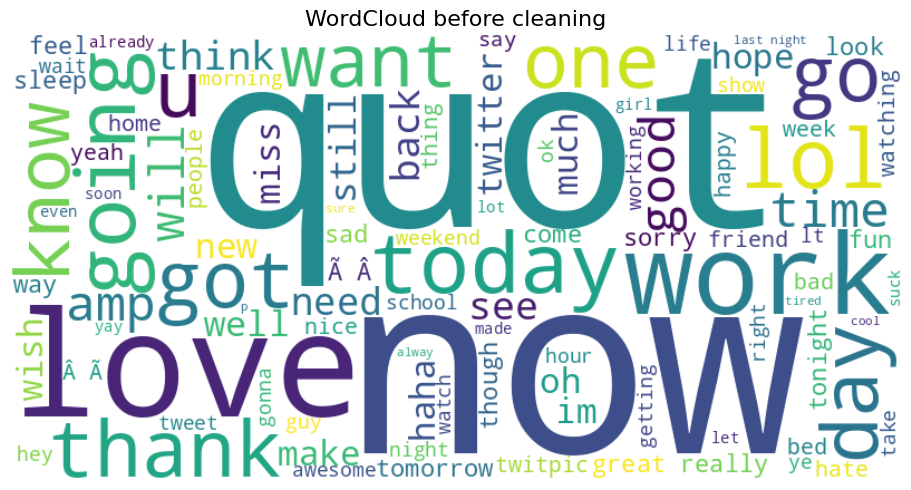

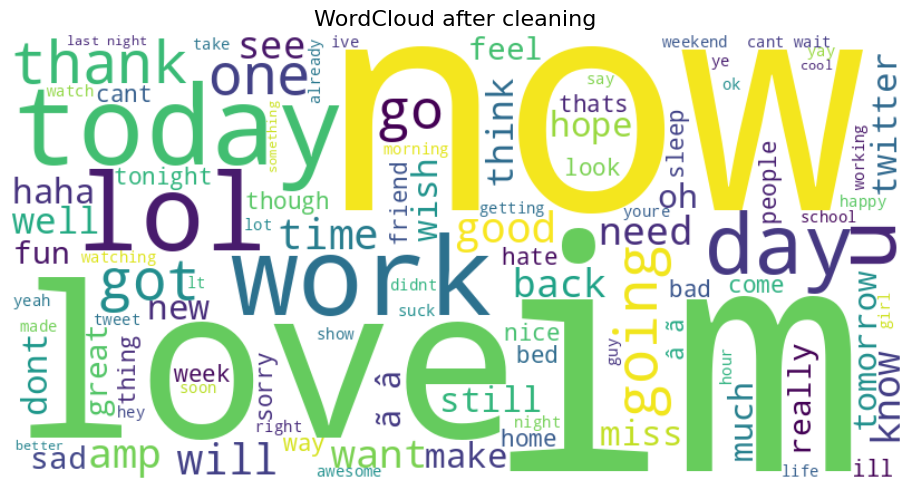

In [23]:
# Wordcloud before and after cleaning
!pip install wordcloud
from wordcloud import WordCloud

def generate_wordcloud(text_series, title, max_words=100):
    text = " ".join(text_series)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

train_df_raw = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/train_dataset.csv")
generate_wordcloud(train_df_raw['Text'], "WordCloud before cleaning")
generate_wordcloud(train_df['Text'], "WordCloud after cleaning")

In [24]:
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(train_df['Text']), padding=True, truncation=True, max_length=64, return_tensors='pt')
val_encodings   = tokenizer(list(val_df['Text']), padding=True, truncation=True, max_length=64, return_tensors='pt')
test_encodings  = tokenizer(list(test_df['Text']), padding=True, truncation=True, max_length=64, return_tensors='pt')

train_labels = torch.tensor(train_df['Label'].values)
val_labels   = torch.tensor(val_df['Label'].values)

# Dataset Class
class TweetDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

# Dataset Instances
train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset   = TweetDataset(val_encodings, val_labels)
test_dataset  = TweetDataset(test_encodings)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64)
test_loader  = DataLoader(test_dataset, batch_size=64)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [25]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

import torch
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

2025-05-20 21:06:21.772650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747775181.959415      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747775182.010960      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPU available: True
GPU: Tesla P100-PCIE-16GB


In [ ]:

!pip install optuna --quiet
import optuna
from transformers import BertForSequenceClassification
import torch
import torch.nn as nn
from torch.utils.data import Subset
from sklearn.metrics import accuracy_score
import random

indices = random.sample(range(len(train_dataset)), 70000)
small_train_dataset = Subset(train_dataset, indices)

indices_val = random.sample(range(len(val_dataset)), 15000)
small_val_dataset = Subset(val_dataset, indices_val)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):
    # Υπερπαράμετροι
    lr = trial.suggest_float("lr", 1e-6, 1e-3, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32,64])
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "SGD", "RMSprop"])
    loss_name = trial.suggest_categorical("loss_fn", ["CrossEntropy", "LabelSmoothing"])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.5)
    clip_value = trial.suggest_float("grad_clip", 0.3, 2.5)

    # DataLoader
    train_loader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(small_val_dataset, batch_size=batch_size, shuffle=False)

    # Μοντέλο
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=2,
        hidden_dropout_prob=dropout
    ).to(device)

    # Επιλογή optimizer
    if optimizer_name == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:  # RMSprop
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Επιλογή loss function
    if loss_name == "CrossEntropy":
        loss_fn = nn.CrossEntropyLoss()
    elif loss_name == "LabelSmoothing":
        loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Training loop
    model.train()
    for epoch in range(2):  # μικρό για tuning
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            loss = loss_fn(logits, batch["labels"])
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()
            optimizer.zero_grad()

    # Αξιολόγηση
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Καθαρισμός
    del model
    torch.cuda.empty_cache()

    acc = accuracy_score(all_labels, all_preds)
    return acc

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40, show_progress_bar=True)

print("Best trial:")
print(study.best_trial)


[I 2025-05-20 21:06:38,367] A new study created in memory with name: no-name-e242060e-922f-4f29-8877-320301719a2e


  0%|          | 0/40 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-05-20 21:19:40,145] Trial 0 finished with value: 0.4962 and parameters: {'lr': 7.405065594904387e-05, 'dropout': 0.48767791405794336, 'batch_size': 64, 'optimizer': 'RMSprop', 'loss_fn': 'LabelSmoothing', 'weight_decay': 0.14350609163857114, 'grad_clip': 2.2120181181401044}. Best is trial 0 with value: 0.4962.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-05-20 21:33:56,605] Trial 1 finished with value: 0.5038 and parameters: {'lr': 0.0003122521009040554, 'dropout': 0.29039136229324736, 'batch_size': 32, 'optimizer': 'AdamW', 'loss_fn': 'CrossEntropy', 'weight_decay': 0.3647040732676436, 'grad_clip': 1.087721312359528}. Best is trial 1 with value: 0.5038.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

import torch
import time
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

from torch.optim import AdamW
from transformers import get_scheduler, BertForSequenceClassification

def train_model(model, train_loader, val_loader,
                lr=2e-5,
                num_epochs=3,
                clip_value=1.0,
                patience=2):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    loss_fn =  nn.CrossEntropyLoss(label_smoothing=0.1)

    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_epochs * len(train_loader)
    )

    best_val_loss = float("inf")
    best_model_state = None
    train_losses, val_losses = [], []
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
       
        model.train()
        running_loss = 0

        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            output = model(**batch)
            loss = output.loss
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
       

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation
        model.eval()
        val_loss = 0
        all_preds, all_labels, all_probs = [], [], []

        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                output = model(**batch)
                loss = output.loss
                val_loss += loss.item()

                logits = output.logits
                probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                labels = batch["labels"].cpu().numpy()

                all_preds.extend(preds)
                all_labels.extend(labels)
                all_probs.extend(probs)

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds)
        rec = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        auc = roc_auc_score(all_labels, all_probs)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement.")
                break

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
        print("Loaded best model (lowest val loss).")

    # Plot Loss Curves
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Learning Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:

train_model(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=6.854021858236762e-06,
    num_epochs=1,
    clip_value=1.5144491971417913,
    patience=2
)


In [ ]:

import torch
import pandas as pd

# Ensure device is defined and model is on it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Prediction loop
predictions = []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())

# Create submission DataFrame
submission_df = pd.DataFrame({
    "ID": test_df["ID"] if "ID" in test_df.columns else range(len(predictions)),
    "Label": predictions
})

# Save to CSV
submission_df.to_csv("submission.csv", index=False)
print("✅ Submission saved as submission.csv")
